In [1]:
import pandas as pd
from rdkit.Chem import MolFromSmiles, MolFromSmarts, BRICS, Draw, Mol, PandasTools

from src.smarts import ActivationSmarts
from src.utils import BRICSDecompositionsToFrame

PandasTools.RenderImagesInAllDataFrames()
PandasTools.molRepresentation = 'svg'

## Choose SMARTS pattern

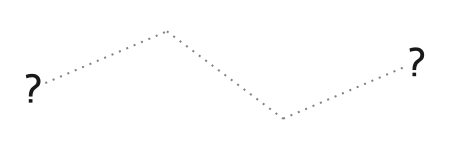

In [2]:
(query_smarts := ActivationSmarts.C4_FG123.as_mol())

## Load the SMILES data (and clean by dropping faulty entries)

In [3]:
df_candidates = pd.read_csv(
    '../data/mapping/known_compounds_240310_v2.txt',
    names=['candidate_smiles'],
    header=None,
    encoding='utf-8',
    sep='\r',
    na_filter=False,
)

PandasTools.AddMoleculeColumnToFrame(df_candidates, smilesCol='candidate_smiles', molCol='candidate_mol', includeFingerprints=True)

[13:39:19] Can't kekulize mol.  Unkekulized atoms: 28 32 33 34 35 36
[13:39:19] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 8 9
[13:39:20] Can't kekulize mol.  Unkekulized atoms: 1 5 6 16 17 18
[13:39:20] Can't kekulize mol.  Unkekulized atoms: 1 5 9 10
[13:39:21] Can't kekulize mol.  Unkekulized atoms: 2 4 5 11
[13:39:21] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 8 9
[13:39:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:39:22] Can't kekulize mol.  Unkekulized atoms: 1 5 6 10 11 12
[13:39:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:39:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:39:22] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 7 12


In [4]:
faults = df_candidates.loc[lambda df: df.candidate_mol.isna()]
df_candidates.dropna(subset=['candidate_mol'], inplace=True)
faults

,candidate_smiles,candidate_mol
2392,Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OCC2OC(N...,None
3696,Nc1[nH]c(=S)c2ncnc2[nH]1,None
4758,Nc1[nH]c(=O)c2c(CNC3C=CC(O)C3O)cnc2[nH]1,None
4862,Nc1[nH]c(=O)c2[nH]c(=O)nc2[nH]1,None
5906,Cn1c[nH]c2nc(=O)[nH]c(=O)c21,None
6412,Nc1[nH]c(=O)c2ncnc2[nH]1,None
6894,Nc1[nH]c(=O)c2c(C(=O)O)cnc2[nH]1,None
8394,NCc1cnc2[nH]c(N)[nH]c(=O)c12,None


## Check for substruct matches (filter down to putative matches)

In [5]:
df_candidates = df_candidates.assign(
    substruct_matches=lambda df: df.candidate_mol.apply(lambda mol: mol.GetSubstructMatches(query=query_smarts))
)

(df_matches_putative := df_candidates.loc[lambda df: df.substruct_matches.apply(bool)])

candidate_smiles  \
81    C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)CC(O)C(=O)C(C)(C...   
127   *NC(C(*)=O)C(C)OC1OC(COC2OC(COS(=O)(=O)O)C(OC3...   
132                                    CC(=O)C(N)C(=O)O   
285   *NC(C(*)=O)C(C)OC1OC(CO)C(O)C(O)C1OC1OC(CO)C(O...   
493                            CC(OP(=O)(O)O)C(N)C(=O)O   
...                                                 ...   
7832  *NC(C(*)=O)C(C)OC1OC(COP(=O)(O)O)C(OC2OC(CO)C(...   
8053  *NC(C(*)=O)C(C)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc3...   
8311                     CC(=O)C(O)C(O)C(=O)COP(=O)(O)O   
8376                         CC(O)C(NC(=O)C(N)CO)C(=O)O   
8630                  CC(O)C(O)C1CNC2=NC(N)=NC(=O)C2=N1   

                                      candidate_mol  \
81    <rdkit.Chem.rdchem.Mol object at 0x14757d7e0>   
127   <rdkit.Chem.rdchem.Mol object at 0x1475800b0>   
132   <rdkit.Chem.rdchem.Mol object at 0x147580510>   
285   <rdkit.Chem.rdchem.Mol object at 0x14758cc10>   
493   <rdkit.Chem.rdchem.Mol object at 0x1475a43c0>   
...                                             ...   
7832  <rdkit.Chem.rdchem.Mol object at 0x15f60cc10>   
8053  <rdkit.Chem.rdchem.Mol object at 0x15f620f20>   
8311  <rdkit.Chem.rdchem.Mol object at 0x15f63b290>   
8376  <rdkit.Chem.rdchem.Mol object at 0x15f642c00>   
8630  <rdkit.Chem.rdchem.Mol object at 0x15f65cba0>   

                         substruct_matches  
81    ((18, 20, 22, 23), (18, 20, 22, 24))  
127                        ((3, 2, 6, 7),)  
132                        ((5, 3, 1, 0),)  
285                        ((3, 2, 6, 7),)  
493                        ((9, 7, 1, 0),)  
...                                    ...  
7832                       ((3, 2, 6, 7),)  
8053                       ((3, 2, 6, 7),)  
8311                       ((5, 3, 1, 0),)  
8376                      ((11, 3, 1, 0),)  
8630                       ((5, 3, 1, 0),)  

[82 rows x 3 columns]

## Perform BRICS decomposition for complex molecules and review

In [6]:
(df_matches_putative := df_matches_putative.assign(**BRICSDecompositionsToFrame(df_matches_putative.candidate_mol)))

candidate_smiles  \
81    C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)CC(O)C(=O)C(C)(C...   
127   *NC(C(*)=O)C(C)OC1OC(COC2OC(COS(=O)(=O)O)C(OC3...   
132                                    CC(=O)C(N)C(=O)O   
285   *NC(C(*)=O)C(C)OC1OC(CO)C(O)C(O)C1OC1OC(CO)C(O...   
493                            CC(OP(=O)(O)O)C(N)C(=O)O   
...                                                 ...   
7832  *NC(C(*)=O)C(C)OC1OC(COP(=O)(O)O)C(OC2OC(CO)C(...   
8053  *NC(C(*)=O)C(C)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc3...   
8311                     CC(=O)C(O)C(O)C(=O)COP(=O)(O)O   
8376                         CC(O)C(NC(=O)C(N)CO)C(=O)O   
8630                  CC(O)C(O)C1CNC2=NC(N)=NC(=O)C2=N1   

                                      candidate_mol  \
81    <rdkit.Chem.rdchem.Mol object at 0x14757d7e0>   
127   <rdkit.Chem.rdchem.Mol object at 0x1475800b0>   
132   <rdkit.Chem.rdchem.Mol object at 0x147580510>   
285   <rdkit.Chem.rdchem.Mol object at 0x14758cc10>   
493   <rdkit.Chem.rdchem.Mol object at 0x1475a43c0>   
...                                             ...   
7832  <rdkit.Chem.rdchem.Mol object at 0x15f60cc10>   
8053  <rdkit.Chem.rdchem.Mol object at 0x15f620f20>   
8311  <rdkit.Chem.rdchem.Mol object at 0x15f63b290>   
8376  <rdkit.Chem.rdchem.Mol object at 0x15f642c00>   
8630  <rdkit.Chem.rdchem.Mol object at 0x15f65cba0>   

                         substruct_matches  \
81    ((18, 20, 22, 23), (18, 20, 22, 24))   
127                        ((3, 2, 6, 7),)   
132                        ((5, 3, 1, 0),)   
285                        ((3, 2, 6, 7),)   
493                        ((9, 7, 1, 0),)   
...                                    ...   
7832                       ((3, 2, 6, 7),)   
8053                       ((3, 2, 6, 7),)   
8311                       ((5, 3, 1, 0),)   
8376                      ((11, 3, 1, 0),)   
8630                       ((5, 3, 1, 0),)   

                                           brics_decomp  \
81    (<rdkit.Chem.rdchem.Mol object at 0x168a52b20>...   
127   (<rdkit.Chem.rdchem.Mol object at 0x168a52a40>...   
132     (<rdkit.Chem.rdchem.Mol object at 0x147580510>)   
285   (<rdkit.Chem.rdchem.Mol object at 0x168a500b0>...   
493   (<rdkit.Chem.rdchem.Mol object at 0x168a50580>...   
...                                                 ...   
7832  (<rdkit.Chem.rdchem.Mol object at 0x168933290>...   
8053  (<rdkit.Chem.rdchem.Mol object at 0x168adbdf0>...   
8311  (<rdkit.Chem.rdchem.Mol object at 0x168adba00>...   
8376  (<rdkit.Chem.rdchem.Mol object at 0x168adbf40>...   
8630  (<rdkit.Chem.rdchem.Mol object at 0x168adbca0>...   

                                       brics_frag_1  \
81    <rdkit.Chem.rdchem.Mol object at 0x168a52b20>   
127   <rdkit.Chem.rdchem.Mol object at 0x168a52a40>   
132   <rdkit.Chem.rdchem.Mol object at 0x147580510>   
285   <rdkit.Chem.rdchem.Mol object at 0x168a500b0>   
493   <rdkit.Chem.rdchem.Mol object at 0x168a50580>   
...                                             ...   
7832  <rdkit.Chem.rdchem.Mol object at 0x168933290>   
8053  <rdkit.Chem.rdchem.Mol object at 0x168adbdf0>   
8311  <rdkit.Chem.rdchem.Mol object at 0x168adba00>   
8376  <rdkit.Chem.rdchem.Mol object at 0x168adbf40>   
8630  <rdkit.Chem.rdchem.Mol object at 0x168adbca0>   

                                       brics_frag_2  \
81    <rdkit.Chem.rdchem.Mol object at 0x168a52c70>   
127   <rdkit.Chem.rdchem.Mol object at 0x168a526c0>   
132                                             NaN   
285   <rdkit.Chem.rdchem.Mol object at 0x168a506d0>   
493   <rdkit.Chem.rdchem.Mol object at 0x168a50820>   
...                                             ...   
7832  <rdkit.Chem.rdchem.Mol object at 0x168932490>   
8053  <rdkit.Chem.rdchem.Mol object at 0x168adbd80>   
8311  <rdkit.Chem.rdchem.Mol object at 0x168adbc30>   
8376  <rdkit.Chem.rdchem.Mol object at 0x168adb4c0>   
8630  <rdkit.Chem.rdchem.Mol object at 0x168adbbc0>   

                                       brics_frag_3  \
81    <rdkit.Chem.rdchem.Mol o

## Filter away any complex molecules (more than one BRICS fragment)

In [7]:
(df_matches := df_matches_putative.loc[lambda df: df.brics_decomp.apply(len) < 2])

candidate_smiles  \
132                          CC(=O)C(N)C(=O)O   
657                           CC(O)C(N)C(=O)O   
687                      CCC(O)(C(C)=O)C(=O)O   
785                      CC(O)C(O)C(O)C(=O)CO   
1613                       CC(C)(O)C(O)C(=O)O   
2196                      CC(=O)C(C)(O)C(=O)O   
2237                  CC(O)C(O)C(O)C(O)C(=O)O   
3853                CC(=O)C(O)C(O)CC(N)C(=O)O   
4222                         CC(=O)C(O)C(O)CO   
4289       CC(O)C(O)C1=Nc2c([nH]c(N)nc2=O)NC1   
4354                          *C(=O)C(N)C(C)O   
5606      CC(O)C(=O)C1=Nc2c([nH]c(N)nc2=O)NC1   
5820                        CC(=O)C(=O)C(O)CO   
6904  CC(O)C(=O)C1=Nc2c([nH]c(=O)[nH]c2=O)NC1   

                                      candidate_mol  \
132   <rdkit.Chem.rdchem.Mol object at 0x147580510>   
657   <rdkit.Chem.rdchem.Mol object at 0x1475b5460>   
687   <rdkit.Chem.rdchem.Mol object at 0x1475b6ea0>   
785   <rdkit.Chem.rdchem.Mol object at 0x1475c0580>   
1613  <rdkit.Chem.rdchem.Mol object at 0x14761a030>   
2196  <rdkit.Chem.rdchem.Mol object at 0x1476522d0>   
2237  <rdkit.Chem.rdchem.Mol object at 0x147658740>   
3853  <rdkit.Chem.rdchem.Mol object at 0x15f1717e0>   
4222  <rdkit.Chem.rdchem.Mol object at 0x15f199d90>   
4289  <rdkit.Chem.rdchem.Mol object at 0x15f1a18c0>   
4354  <rdkit.Chem.rdchem.Mol object at 0x15f1a5230>   
5606  <rdkit.Chem.rdchem.Mol object at 0x15f426180>   
5820  <rdkit.Chem.rdchem.Mol object at 0x15f43de70>   
6904  <rdkit.Chem.rdchem.Mol object at 0x15f4a98c0>   

                 substruct_matches  \
132                ((5, 3, 1, 0),)   
657                ((5, 3, 1, 0),)   
687                ((7, 2, 4, 5),)   
785                ((5, 3, 1, 0),)   
1613  ((6, 4, 1, 0), (6, 4, 1, 2))   
2196               ((6, 3, 1, 0),)   
2237               ((5, 3, 1, 0),)   
3853               ((5, 3, 1, 0),)   
4222               ((5, 3, 1, 0),)   
4289               ((5, 3, 1, 0),)   
4354               ((1, 3, 5, 6),)   
5606               ((5, 3, 1, 0),)   
5820               ((5, 3, 1, 0),)   
6904               ((5, 3, 1, 0),)   

                                         brics_decomp  \
132   (<rdkit.Chem.rdchem.Mol object at 0x147580510>)   
657   (<rdkit.Chem.rdchem.Mol object at 0x1475b5460>)   
687   (<rdkit.Chem.rdchem.Mol object at 0x1475b6ea0>)   
785   (<rdkit.Chem.rdchem.Mol object at 0x1475c0580>)   
1613  (<rdkit.Chem.rdchem.Mol object at 0x14761a030>)   
2196  (<rdkit.Chem.rdchem.Mol object at 0x1476522d0>)   
2237  (<rdkit.Chem.rdchem.Mol object at 0x147658740>)   
3853  (<rdkit.Chem.rdchem.Mol object at 0x15f1717e0>)   
4222  (<rdkit.Chem.rdchem.Mol object at 0x15f199d90>)   
4289  (<rdkit.Chem.rdchem.Mol object at 0x15f1a18c0>)   
4354  (<rdkit.Chem.rdchem.Mol object at 0x15f1a5230>)   
5606  (<rdkit.Chem.rdchem.Mol object at 0x15f426180>)   
5820  (<rdkit.Chem.rdchem.Mol object at 0x15f43de70>)   
6904  (<rdkit.Chem.rdchem.Mol object at 0x15f4a98c0>)   

                                       brics_frag_1 brics_frag_2 brics_frag_3  \
132   <rdkit.Chem.rdchem.Mol object at 0x147580510>          NaN          NaN   
657   <rdkit.Chem.rdchem.Mol object at 0x1475b5460>          NaN          NaN   
687   <rdkit.Chem.rdchem.Mol object at 0x1475b6ea0>          NaN          NaN   
785   <rdkit.Chem.rdchem.Mol object at 0x1475c0580>          NaN          NaN   
1613  <rdkit.Chem.rdchem.Mol object at 0x14761a030>          NaN          NaN   
2196  <rdkit.Chem.rdchem.Mol object at 0x1476522d0>          NaN          NaN   
2237  <rdkit.Chem.rdchem.Mol object at 0x147658740>          NaN          NaN   
3853  <rdkit.Chem.rdchem.Mol object at 0x15f1717e0>          NaN          NaN   
4222  <rdkit.Chem.rdchem.Mol object at 0x15f199d90>          NaN          NaN   
4289  <rdkit.Chem.rdchem.Mol object at 0x15f1a18c0>          NaN          NaN   
4354  <rdkit.Chem.rdchem.Mol object at 0x15f1a5230>          NaN          NaN   
5606  <rdkit.Chem.rdchem.Mol object at 0x15f426180>          NaN    

## Serialize back out (potentially to Excel with images)

In [9]:
PandasTools.SaveXlsxFromFrame(df_matches_putative, '/Users/pasha/Desktop/c4_activations.xlsx', molCol='candidate_mol')